In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import Module, Conv2d, Linear, MaxPool2d, ReLU, LogSoftmax
from torch import flatten
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms.v2 as transforms
import os
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from PIL import Image
from torch.utils.data import DataLoader, random_split
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.utils import shuffle
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def load_data(dir_list, image_size):
    X = []
    y = []
    
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # crop the brain and ignore the unnecessary rest part of the image
            image = cv2.imread(directory + '\\' + filename)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])  
                
    X = np.array(X)
    y = np.array(y)
    
    
    # Shuffle the data
    X, y = shuffle(X, y)

    # X = torch.tensor(X.transpose(0,3,1,2))

    
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')


    
    return X, y

In [4]:
augmented_path = 'C:/Users/aytem/Desktop/testgit/5820-Final-Project/data'

# augmented data (yes and no) contains both the original and the new generated examples
data_yes = augmented_path + '/yes' 
data_no = augmented_path + '/no'


IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([data_yes, data_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 253
X shape is: (253, 240, 240, 3)
y shape is: (253, 1)


In [5]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

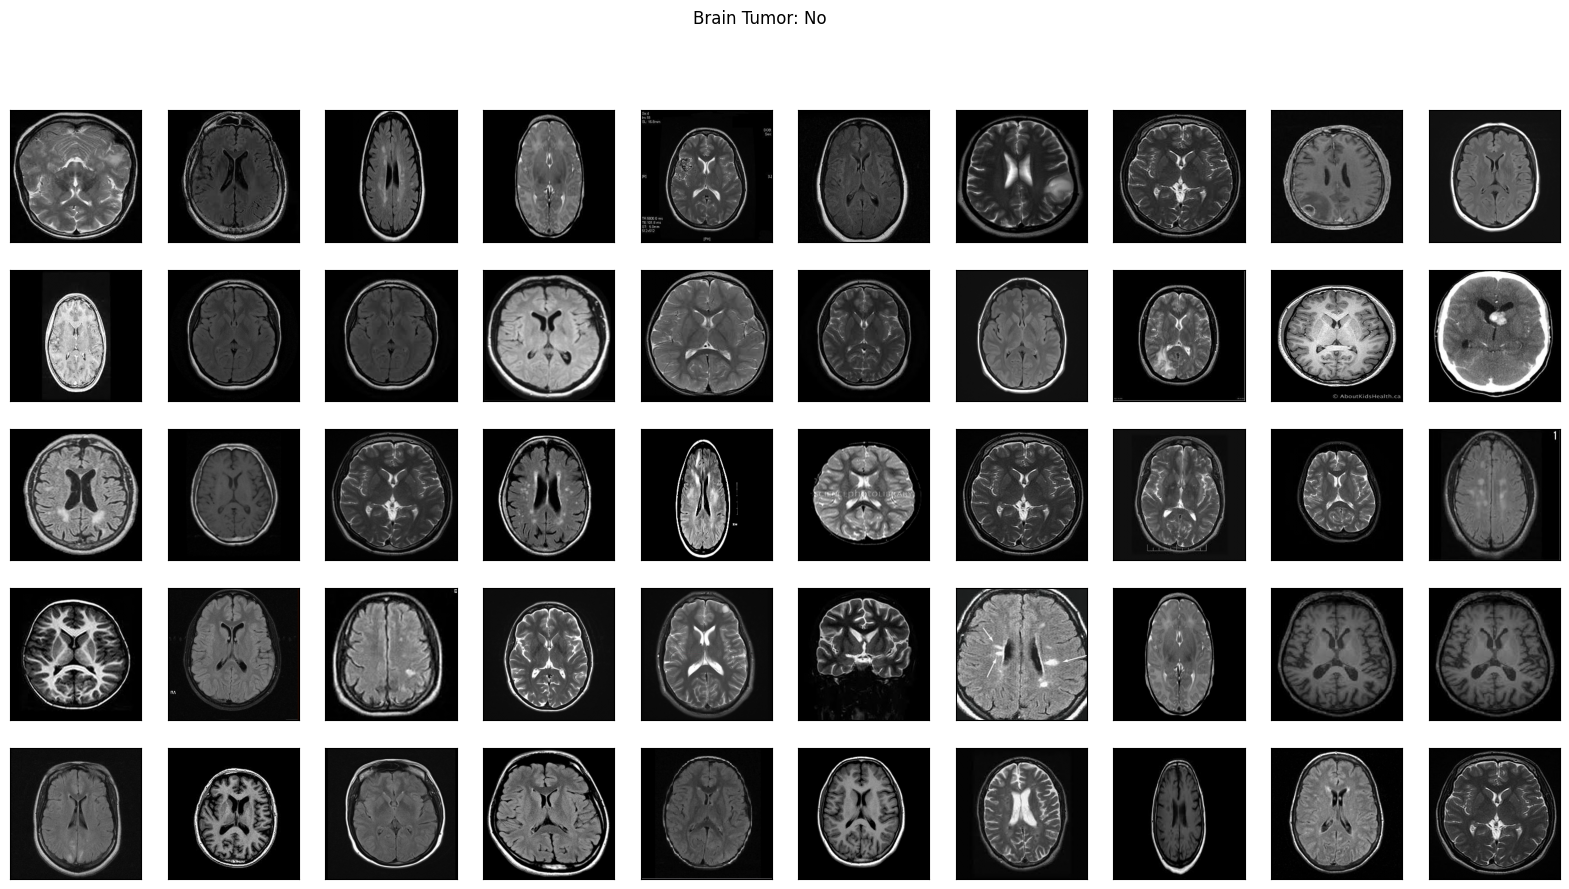

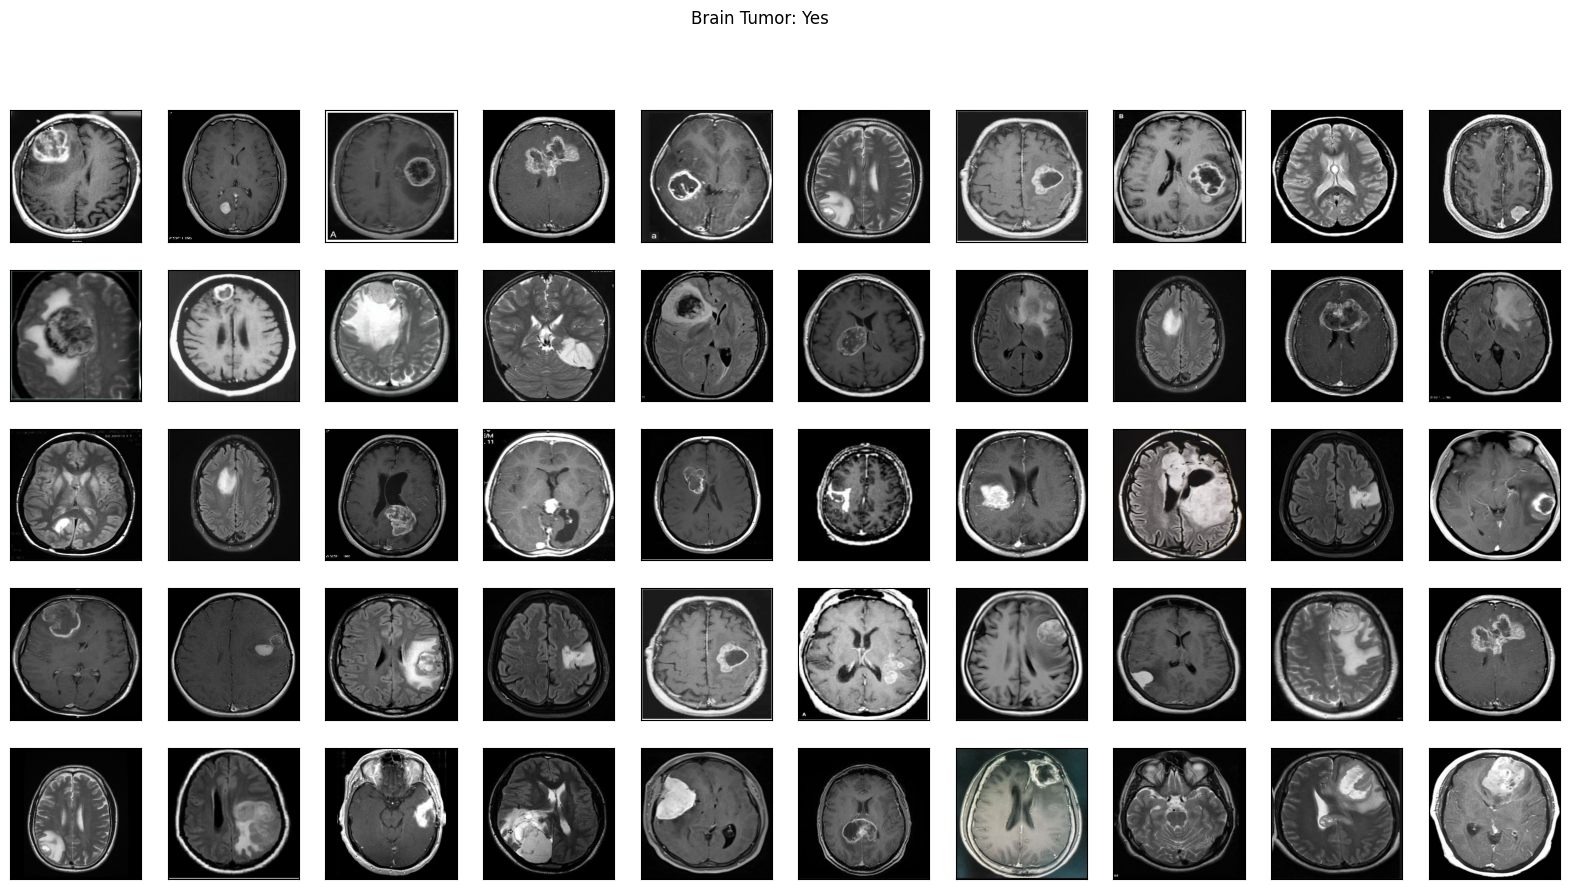

In [6]:
plot_sample_images(X, y)

In [7]:
def split_data(X, y, test_size):  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    return X_train, y_train, X_test, y_test

In [8]:
X_train, y_train, X_test, y_test = split_data(X, y, test_size=0.3)

In [9]:
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

training_data = torch.utils.data.TensorDataset(X_train, y_train)
testing_data = torch.utils.data.TensorDataset(X_test, y_test)


In [10]:
import torch.utils
import torch.utils.data

train_loader = torch.utils.data.DataLoader(training_data, batch_size=10, shuffle=True)
validation_loader = torch.utils.data.DataLoader(testing_data, batch_size=10, shuffle=False)

In [11]:
print('Training set has {} instances'.format(len(training_data)))
print('Validation set has {} instances'.format(len(testing_data)))

Training set has 177 instances
Validation set has 76 instances


In [12]:
IMG_SHAPE = (240, 240, 3) 
class BrainDetectionModel(nn.Module):
    def __init__(self, input_shape):
        super(BrainDetectionModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_shape[2], out_channels=32, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(4, 4))
        self.pool2 = nn.MaxPool2d(kernel_size=(4, 4))
        self.fc1 = nn.Linear(6272, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.sigmoid(x)
        return x

model = BrainDetectionModel(IMG_SHAPE)


In [13]:
from torchsummary import summary
summary(model, input_size=IMG_SHAPE)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            4,736
├─BatchNorm2d: 1-2                       64
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─MaxPool2d: 1-5                         --
├─Linear: 1-6                            6,273
├─Sigmoid: 1-7                           --
Total params: 11,073
Trainable params: 11,073
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            4,736
├─BatchNorm2d: 1-2                       64
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─MaxPool2d: 1-5                         --
├─Linear: 1-6                            6,273
├─Sigmoid: 1-7                           --
Total params: 11,073
Trainable params: 11,073
Non-trainable params: 0

In [14]:
def train_dataset(model, train_loader, validation_loader):
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.BCELoss()
    
    num_epochs = 25

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.transpose(1,3).transpose(2,3)           
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch + 1}/250], Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs = inputs.transpose(1,3).transpose(2,3)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

        val_loss /= len(validation_loader.dataset)
        print(f"Validation Loss: {val_loss:.4f}")

In [15]:
train_dataset(model, train_loader, validation_loader)

Epoch [1/10], Loss: 0.9590
Validation Loss: 0.5859
Epoch [2/10], Loss: 0.6177
Validation Loss: 0.4962
Epoch [3/10], Loss: 0.4991
Validation Loss: 0.4049
Epoch [4/10], Loss: 0.3327
Validation Loss: 0.4424
Epoch [5/10], Loss: 0.2724
Validation Loss: 0.4363
Epoch [6/10], Loss: 0.2757
Validation Loss: 0.4334
Epoch [7/10], Loss: 0.1670
Validation Loss: 0.4719
Epoch [8/10], Loss: 0.1277
Validation Loss: 0.4303
Epoch [9/10], Loss: 0.0896
Validation Loss: 0.4891
Epoch [10/10], Loss: 0.0964
Validation Loss: 0.4520
Epoch [11/10], Loss: 0.1038
Validation Loss: 0.4578
Epoch [12/10], Loss: 0.0919
Validation Loss: 0.5122
Epoch [13/10], Loss: 0.0589
Validation Loss: 0.5293
Epoch [14/10], Loss: 0.0533
Validation Loss: 0.4977
Epoch [15/10], Loss: 0.0571
Validation Loss: 0.4346
Epoch [16/10], Loss: 0.0349
Validation Loss: 0.4757
Epoch [17/10], Loss: 0.0245
Validation Loss: 0.5081
Epoch [18/10], Loss: 0.0222
Validation Loss: 0.5694
Epoch [19/10], Loss: 0.0295
Validation Loss: 0.5379
Epoch [20/10], Loss: 